In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras import backend as K

In [27]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 1 0 1 0 1 1 1 0 1 1 1 1 1 2 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0]


In [6]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

3 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


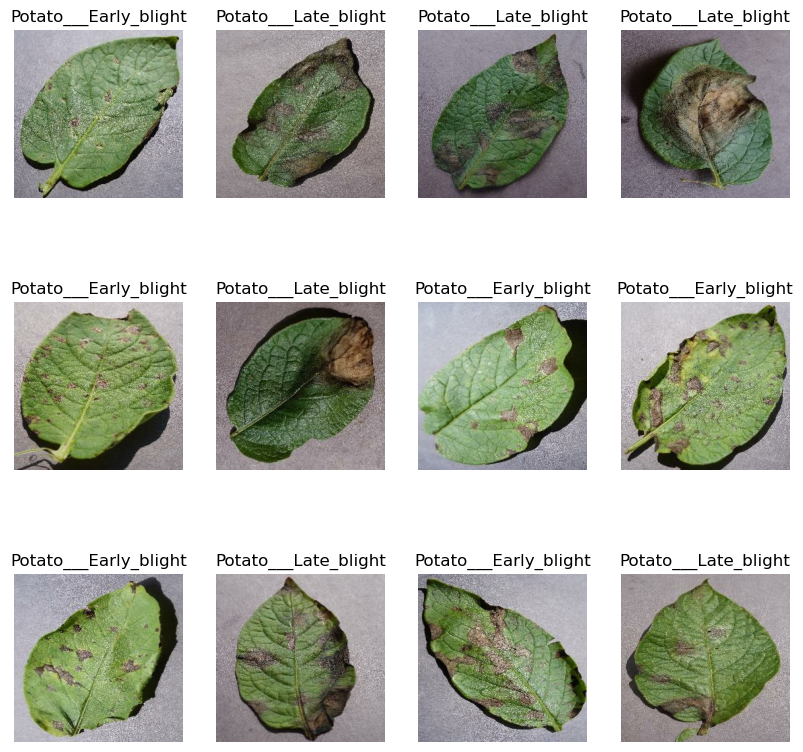

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

68

In [9]:
# train_size = 0.8
# val_size = 0.1
# test_size = 0.1

# train_ds = dataset.take(int(len(dataset) * train_size))
# test_ds = dataset.skip(int(len(dataset) * train_size))

# val_ds = test_ds.take(int(len(dataset) * val_size))
# test_ds = test_ds.skip(int(len(dataset) * val_size))

# print(f"train size: {len(train_ds)}")
# print(f"val size: {len(val_ds)}")
# print(f"test size: {len(test_ds)}")

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    # assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
print(f"train size: {len(train_ds)}")
print(f"val size: {len(val_ds)}")
print(f"test size: {len(test_ds)}")

train size: 54
val size: 6
test size: 8


In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
print(f"train size: {len(train_ds)}")
print(f"val size: {len(val_ds)}")
print(f"test size: {len(test_ds)}")

train size: 54
val size: 6
test size: 8


In [15]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(None, None, 3)),  # Input layer to accept images of any size
    tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE))),  # Resize images
    tf.keras.layers.Rescaling(1./255)  # Rescale pixel values to [0, 1]
])

In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.InputLayer(shape=(None, None, 3)),  # Input layer to accept images of any size
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [17]:
print(resize_and_rescale)
print(data_augmentation)

<Sequential name=sequential, built=True>
<Sequential name=sequential_1, built=True>


In [18]:
# input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# chanDim = -1
# if K.image_data_format() == "channels_first":
#     input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
#     batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
#     chanDim = 1

In [19]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    # layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# model.build(input_shape=batch_input_shape)

In [20]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 631ms/step - accuracy: 0.9142 - loss: 0.2379 - val_accuracy: 0.8906 - val_loss: 0.2903
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 583ms/step - accuracy: 0.9106 - loss: 0.2508 - val_accuracy: 0.9427 - val_loss: 0.1264
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 615ms/step - accuracy: 0.9308 - loss: 0.1655 - val_accuracy: 0.9427 - val_loss: 0.1263
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 646ms/step - accuracy: 0.9460 - loss: 0.1335 - val_accuracy: 0.9323 - val_loss: 0.1562
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 722ms/step - accuracy: 0.9560 - loss: 0.1235 - val_accuracy: 0.9583 - val_loss: 0.1032
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 712ms/step - accuracy: 0.9411 - loss: 0.1519 - val_accuracy: 0.9583 - val_loss: 0.1014
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 717ms/step - accuracy: 0.9660 - loss: 0.0848 - val_accuracy: 0.9115 - val_loss: 0.2171
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 720ms/step - accuracy: 0.9657 - loss: 0.0982 - val_accu

In [29]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - accuracy: 0.9524 - loss: 0.1672


In [30]:
scores

[0.14455249905586243, 0.95703125]

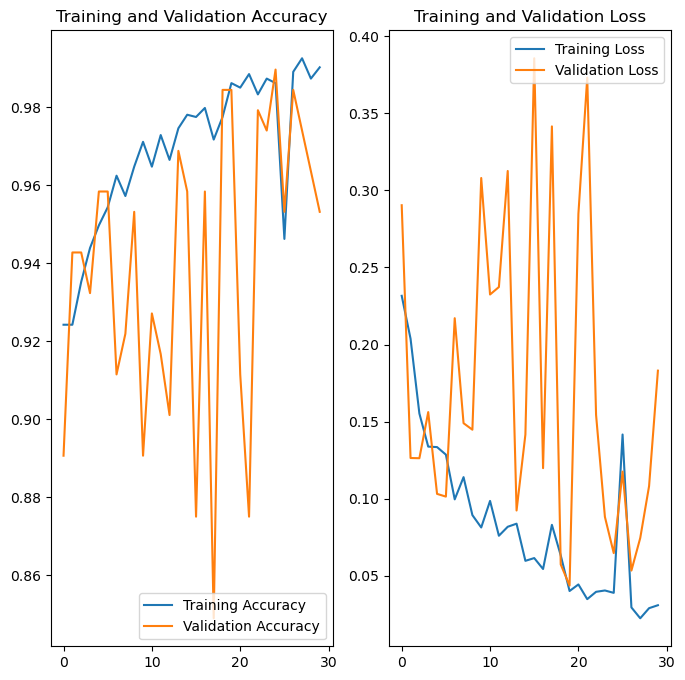

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


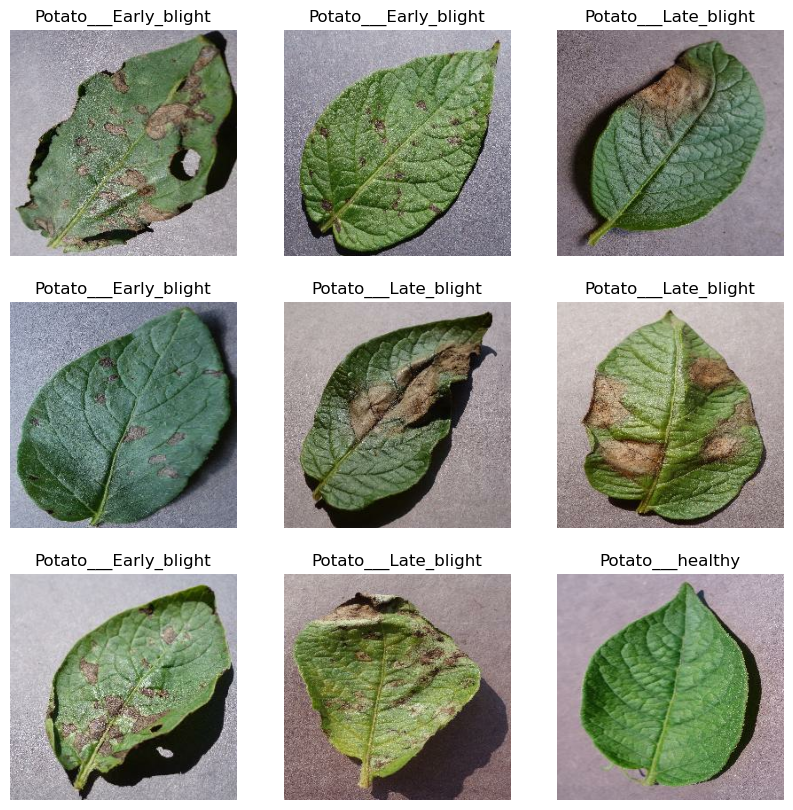

In [41]:
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


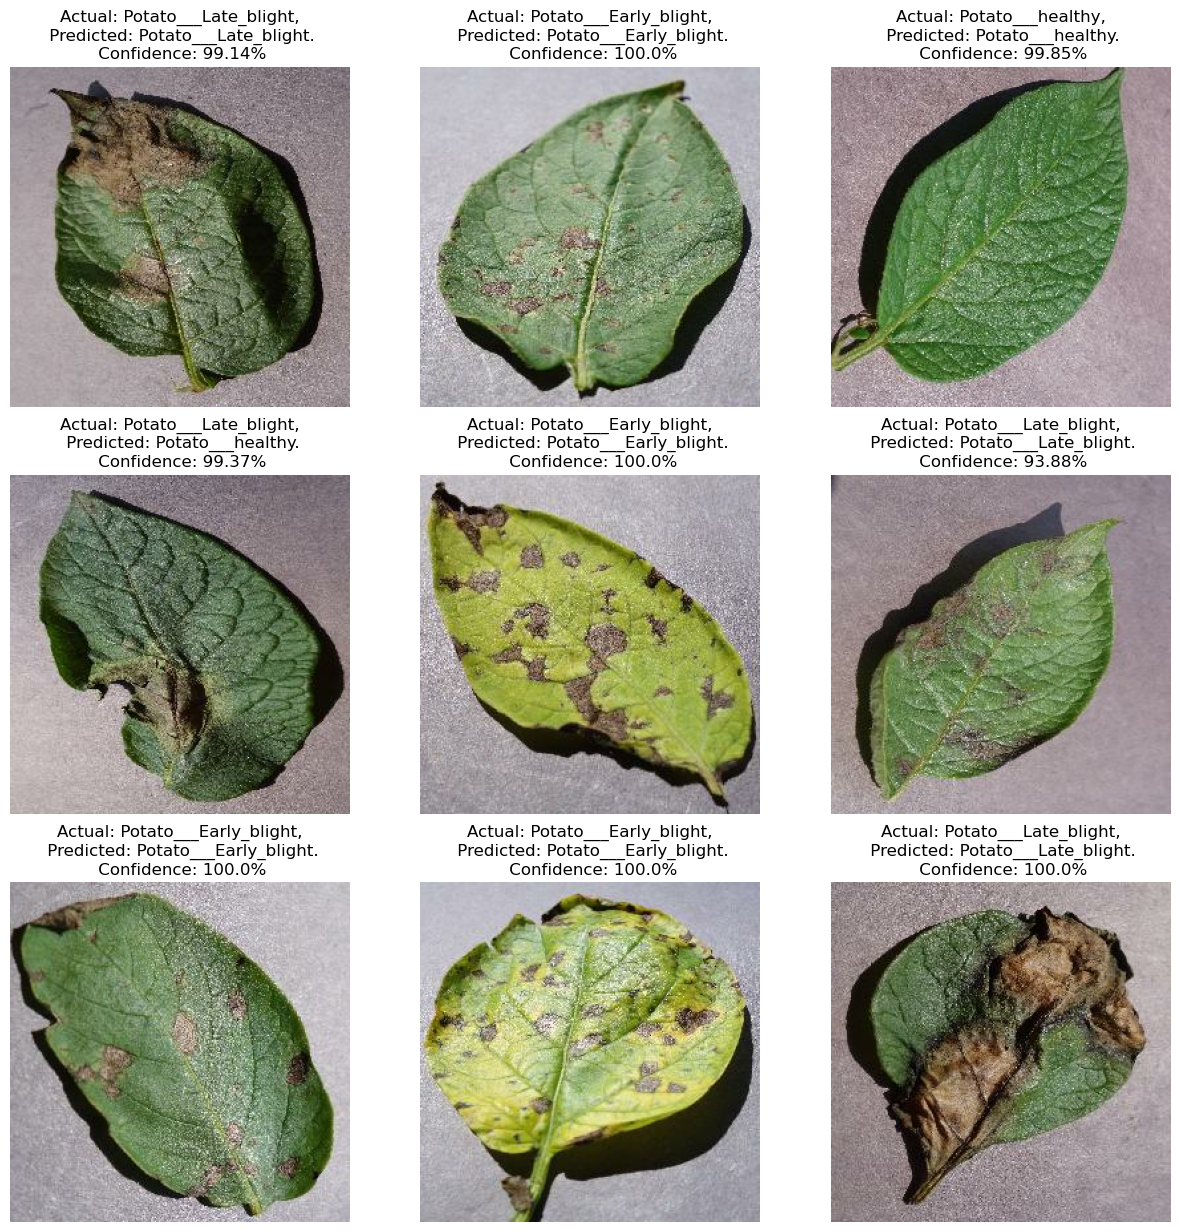

In [43]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [44]:
import os

# Determine the next model version
model_version = max([int(i) for i in (os.listdir("../saved_models") + ["0"])]) + 1
model_save_path = f"../saved_models/{model_version}"

# Save the model in the TensorFlow SavedModel format
model.export(model_save_path)

# Verify the saved model directory structure
print(f"Model saved to: {model_save_path}")

INFO:tensorflow:Assets written to: ../saved_models/1\assets


INFO:tensorflow:Assets written to: ../saved_models/1\assets


Saved artifact at '../saved_models/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='keras_tensor_8')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1378968690832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378968691024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378968693136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378968693328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378968694288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378968695632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378968694480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378968696016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378968695440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378968696400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378968696208: TensorSpec(sha